# Earthquake
2024-02-01

This is an example analysis of the Earthquake data for Haiti

Earthquake

In [ ]:
import datetime as dt
import statistics
import pandas as pd
from climada.util.api_client import Client

client = Client()

In [ ]:
earthquake = client.get_hazard("earthquake", properties={
                        "country_iso3alpha": "HTI",
                    })
earthquakes = []
for i, event_intensity in enumerate(earthquake.intensity):
    total_intensity = max(event_intensity.toarray().flatten())
    if total_intensity > 0.0:
        event_date = dt.datetime.fromordinal(earthquake.date[i]).isoformat()[0:10]
        # print(event_date, total_intensity)
        earthquakes.append([event_date, total_intensity])
earthquake_dt = pd.DataFrame(earthquakes)
earthquake_dt.columns= ["date", "total intensity"]
earthquake_dt.plot(y="total intensity",x="date", kind="bar")
print(f"Number of earthquakes:{len(earthquakes)}", flush=True)
average_max_intensity = statistics.mean([x[1] for x in earthquakes]) 
overall_max_intensity = max([x[1] for x in earthquakes])
print(f"Average max intensity: {round(average_max_intensity,2)}", flush=True)
print(f"Overall max intensity: {round(overall_max_intensity,2)}", flush=True)
earthquake.plot_intensity(0)

In [ ]:
import math
def calc_zoom(df):
  width_y = max(df["latitude"]) - min(df["latitude"])
  width_x = max(df["longitude"]) - min(df["longitude"])
  zoom_y = -1.446*math.log(width_y) + 7.2753
  zoom_x = -1.415*math.log(width_x) + 8.7068
  return min(round(zoom_y,2),round(zoom_x,2))

In [ ]:
import plotly.express as px
max_intensity = np.max(earthquake.intensity, axis=0).toarray().flatten()

latitudes = earthquake.centroids.lat
longitudes = earthquake.centroids.lon
country_data = pd.DataFrame({"latitude":latitudes, "longitude":longitudes, "value":max_intensity})
country_data["value"] = (country_data["value"]- min(country_data["value"])) 
zoom = calc_zoom(country_data)
fig = px.scatter_mapbox(country_data, 
                        lat="latitude", lon="longitude",
                        color="value",
                        size="value", size_max=20, 
                        zoom=zoom, opacity=0.75, 
                         mapbox_style='carto-darkmatter',

                         width=1200, height=800)
fig.show()

In [ ]:
from hdx_scraper_climada.climada_interface import calculate_earthquake_timeseries_admin
from hdx_scraper_climada.download_admin1_geometry import get_admin2_shapes_from_hdx
# earthquakes = calculate_earthquake_timeseries_admin("Haiti")

admin1_names, admin2_names, admin2_shapes = get_admin2_shapes_from_hdx("HTI")



In [ ]:
# Small change to check nbstripout is working
import geopandas
import pandas
all_shapes = geopandas.GeoDataFrame( pandas.concat(admin2_shapes, ignore_index=True) )
all_shapes["admin1_names"] = admin1_names
all_shapes["admin2_names"] = admin2_names
all_shapes.plot(column = "admin2_names", categorical=True, cmap='Spectral')

{'1953-05-31', '1979-03-23', '1987-09-03', '1914-02-28', '1962-01-08', '2010-01-12', '1960-09-14', '1946-08-04', '1948-04-21', '1950-08-13', '1973-08-03', '1907-01-14', '2003-09-22', '1984-06-24', '1947-08-07', '1953-01-25', '1991-03-26', '1992-01-15', '1916-11-30', '1972-09-19', '1956-07-09', '1911-10-06', '1994-07-12', '1946-08-08', '2010-03-20', '1988-09-05', '1962-04-20', '2010-01-13', '1946-08-21', '1948-04-23', '1945-01-22', '1946-08-24', '1932-02-03', '1948-04-22', '1971-06-11', '1952-10-28', '2010-01-20'}


<Axes: >

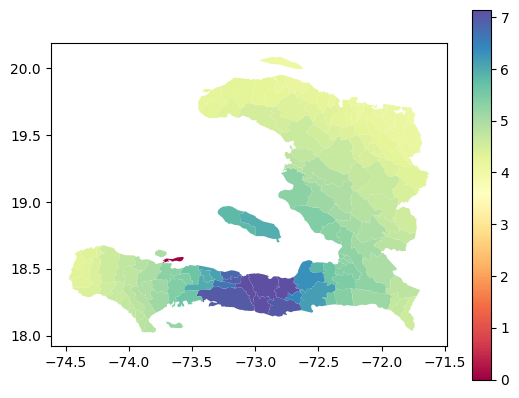

In [9]:
import csv
with open("admin1-timeseries-summaries.csv", encoding="utf-8") as summary_file:
    summary_data = list(csv.DictReader(summary_file))

date_set = set(x["event_date"] for x in summary_data)
print(date_set, flush=True)
values = {x["admin2_name"]:x["value"] for x in summary_data if x["event_date"] == "2010-01-13"}
value_column = [float(values.get(x, 0.0)) for x in admin2_names]
all_shapes = geopandas.GeoDataFrame( pandas.concat(admin2_shapes, ignore_index=True) )
all_shapes["admin1_names"] = admin1_names
all_shapes["admin2_names"] = admin2_names
all_shapes["value"] = value_column
all_shapes.plot(column = "value", cmap='Spectral', legend=True)